In [ ]:
# reference to the research paper
# Pre-trained deep recurrent neural network for time series classification
# https://arxiv.org/pdf/1706.08838

In [1]:
#importing all the necessary libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam


In [2]:
# --------------------------
# Reproducibility
# --------------------------
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [3]:
# --------------------------
# User-configurable params
# --------------------------
CSV_PATH = "/content/drive/MyDrive/Coding/Stock price prediction model/microsoft_stock_data.csv"  # change if needed
DATE_COLUMN = "Date"
CLOSE_COLUMN = "Close/Last"
SEQ_LEN = 60         # use last 60 days to predict next day
BATCH_SIZE = 32
PRETRAIN_EPOCHS = 15   # pre-training on sine wave
FINETUNE_EPOCHS = 20   # fine-tune on stock data
LR_PRETRAIN = 0.001
LR_FINETUNE = 0.0005


In [4]:
# --------------------------
# Helper functions
# --------------------------

def create_sequences(values, seq_len):
    """
    Create overlapping sequences for supervised learning.
    values: 1D numpy array (scaled values)
    Returns: X (num_samples, seq_len, 1), y (num_samples,)
    """
    X, y = [], []
    for i in range(len(values) - seq_len):
        X.append(values[i:i+seq_len])
        y.append(values[i+seq_len])
    X = np.array(X)
    y = np.array(y)
    X = np.expand_dims(X, axis=-1)
    return X, y

In [5]:
# --------------------------
# 1) Build base LSTM layer & pre-trainable model
# --------------------------

base_lstm_units = 64
base_lstm_layer = layers.LSTM(base_lstm_units, name="base_lstm")

def build_pretrain_model(input_seq_len, lstm_layer, lr=LR_PRETRAIN):
    """
    Build an end-to-end model for pre-training on synthetic data.
    We keep the LSTM layer separate and pass it in so it can be reused later.
    """
    inp = Input(shape=(input_seq_len, 1), name="input")
    x = lstm_layer(inp)
    out = layers.Dense(1, activation="linear", name="pretrain_output")(x)
    model = models.Model(inputs=inp, outputs=out, name="pretrain_model")
    model.compile(optimizer=Adam(learning_rate=lr), loss="mse")
    return model


In [6]:
# --------------------------
# 2) Generate synthetic general dataset (sine wave with noise)
# --------------------------
def generate_sine_dataset(total_points=6000, noise_std=0.1):
    """
    Generate a noisy sine-wave time series for 'general' pre-training.
    Returns a 1D numpy array.
    """
    t = np.arange(total_points)
    signal = (np.sin(0.02*t) + 0.5*np.sin(0.05*t + 1.5) + 0.2*np.sin(0.13*t*0.7))
    noise = np.random.normal(scale=noise_std, size=total_points)
    data = signal + noise
    data = (data - data.min()) / (data.max() - data.min())
    return data

print("Generating synthetic dataset for pre-training...")
synthetic = generate_sine_dataset(total_points=6000, noise_std=0.08)
X_syn, y_syn = create_sequences(synthetic, SEQ_LEN)
print(f"Synthetic dataset shape X:{X_syn.shape} y:{y_syn.shape}")

print("Building pre-training model...")
pretrain_model = build_pretrain_model(SEQ_LEN, base_lstm_layer, lr=LR_PRETRAIN)
pretrain_model.summary()

print(f"Pre-training on synthetic data for {PRETRAIN_EPOCHS} epochs...")
history = pretrain_model.fit(
    X_syn, y_syn,
    epochs=PRETRAIN_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    verbose=2
)
print("Pre-training completed.\n")

Generating synthetic dataset for pre-training...
Synthetic dataset shape X:(5940, 60, 1) y:(5940,)
Building pre-training model...


Model: "pretrain_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ base_lstm (LSTM)                │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pretrain_output (Dense)         │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Pre-training on synthetic data for 15 epochs...
Epoch 1/15
168/168 - 13s - 79ms/step - loss: 0.0098 - val_loss: 0.0010
Epoch 2/15
168/168 - 4s - 25ms/step - loss: 8.6791e-04 - val_loss: 8.6838e-04
Epoch 3/15
168/168 - 4s - 24ms/step - loss: 8.0311e-04 - val_loss: 8.2879e-04
Epoch 4/15
168/168 - 6s - 37ms/step - loss: 7.6686e-04 - val_loss: 7.8886e-04
Epoch 5/15
168/168 - 4s - 26ms/step - loss: 7.3614e-04 - val_loss: 7.5107e-04
Epoch 6/15
168/168 - 5s - 28ms/step - loss: 7.1830e-04 - val_loss: 7.2867e-04
Epoch 7/15
168/168 - 5s - 31ms/step - loss: 7.1056e-04 - val_loss: 7.2336e-04
Epoch 8/15
168/168 - 4s - 24ms/step - loss: 7.0560e-04 - val_loss: 7.2212e-04
Epoch 9/15
168/168 - 4s - 26ms/step - loss: 7.0182e-04 - val_loss: 7.2106e-04
Epoch 10/15
168/168 - 6s - 33ms/step - loss: 6.9871e-04 - val_loss: 7.2016e-04
Epoch 11/15
168/168 - 4s - 24ms/step - loss: 6.9596e-04 - val_loss: 7.1953e-04
Epoch 12/15
168/168 - 6s - 36ms/step - loss: 6.9346e-04 - val_loss: 7.1924e-04
Epoch 13/15
168/168 

In [7]:
# --------------------------
# 3) Load and prepare Microsoft stock data
# --------------------------
print(f"Loading Microsoft data from: {CSV_PATH}")
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV file not found at {CSV_PATH}. Please place your file there or update CSV_PATH.")

df = pd.read_csv(CSV_PATH, parse_dates=[DATE_COLUMN], infer_datetime_format=True)
df = df[[DATE_COLUMN, CLOSE_COLUMN]].dropna().copy()
df.set_index(DATE_COLUMN, inplace=True)
df.sort_index(inplace=True)

print(f"Loaded {len(df)} records. Date range: {df.index.min()} to {df.index.max()}")

values = df[CLOSE_COLUMN].values.reshape(-1, 1).astype(np.float32)

# Chronological 80/10/10 split
total_len = len(values)
train_end = int(total_len * 0.8)
val_end = int(total_len * 0.9)

# Fit scaler only on training data to avoid data leakage
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(values[:train_end])
values_scaled = scaler.transform(values).flatten()

# Create sequences
X_all, y_all = create_sequences(values_scaled, SEQ_LEN)
num_samples = X_all.shape[0]

# Adjust split indexes for sequences
train_samples = int(num_samples * 0.8)
val_samples = int(num_samples * 0.9)

# Split chronologically
X_train, y_train = X_all[:train_samples], y_all[:train_samples]
X_val, y_val = X_all[train_samples:val_samples], y_all[train_samples:val_samples]
X_test, y_test = X_all[val_samples:], y_all[val_samples:]

print(f"Train samples: {X_train.shape[0]}, Val samples: {X_val.shape[0]}, Test samples: {X_test.shape[0]}")

Loading Microsoft data from: /content/drive/MyDrive/Coding/Stock price prediction model/microsoft_stock_data.csv


/tmp/ipython-input-2268186513.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(CSV_PATH, parse_dates=[DATE_COLUMN], infer_datetime_format=True)


Loaded 2513 records. Date range: 2015-10-09 00:00:00 to 2025-10-07 00:00:00
Train samples: 1962, Val samples: 245, Test samples: 246


In [8]:
# --------------------------
# 4) Build transfer model: reuse pre-trained LSTM (frozen) + new head
# --------------------------
base_lstm_layer.trainable = False  # freeze LSTM weights

finetune_input = Input(shape=(SEQ_LEN, 1), name="finetune_input")
x = base_lstm_layer(finetune_input)
x = layers.Dense(32, activation="relu", name="finetune_dense_1")(x)
x = layers.Dropout(0.2)(x)
finetune_output = layers.Dense(1, activation="linear", name="finetune_output")(x)

finetune_model = models.Model(inputs=finetune_input, outputs=finetune_output, name="finetune_model")

finetune_model.compile(optimizer=Adam(learning_rate=LR_FINETUNE), loss="mse")
finetune_model.summary()

Model: "finetune_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ finetune_input (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ base_lstm (LSTM)                │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ finetune_dense_1 (Dense)        │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ finetune_output (Dense)         │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 2,113 (8.25 KB)

 Non-trainable params: 16,896 (66.00 KB)

In [9]:
# --------------------------
# 5) Fine-tune on Microsoft training data
# --------------------------
print("Fine-tuning on Microsoft training data...")
history_ft = finetune_model.fit(
    X_train, y_train,
    epochs=FINETUNE_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    verbose=2
)
print("Fine-tuning completed.\n")

Fine-tuning on Microsoft training data...
Epoch 1/20
62/62 - 3s - 45ms/step - loss: 0.1223 - val_loss: 0.2565
Epoch 2/20
62/62 - 1s - 17ms/step - loss: 0.0118 - val_loss: 0.0168
Epoch 3/20
62/62 - 1s - 15ms/step - loss: 0.0061 - val_loss: 0.0147
Epoch 4/20
62/62 - 1s - 21ms/step - loss: 0.0061 - val_loss: 0.0153
Epoch 5/20
62/62 - 1s - 21ms/step - loss: 0.0057 - val_loss: 0.0125
Epoch 6/20
62/62 - 1s - 16ms/step - loss: 0.0059 - val_loss: 0.0100
Epoch 7/20
62/62 - 1s - 15ms/step - loss: 0.0056 - val_loss: 0.0072
Epoch 8/20
62/62 - 1s - 15ms/step - loss: 0.0050 - val_loss: 0.0057
Epoch 9/20
62/62 - 2s - 27ms/step - loss: 0.0050 - val_loss: 0.0096
Epoch 10/20
62/62 - 1s - 24ms/step - loss: 0.0049 - val_loss: 0.0084
Epoch 11/20
62/62 - 2s - 33ms/step - loss: 0.0044 - val_loss: 0.0073
Epoch 12/20
62/62 - 1s - 15ms/step - loss: 0.0046 - val_loss: 0.0051
Epoch 13/20
62/62 - 1s - 15ms/step - loss: 0.0046 - val_loss: 0.0036
Epoch 14/20
62/62 - 1s - 16ms/step - loss: 0.0042 - val_loss: 0.0040
E

In [10]:
# --------------------------
# 6) Predictions & Evaluation
# --------------------------
print("Predicting on test set...")
y_pred_scaled = finetune_model.predict(X_test).flatten()

y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_actual = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

rmse = math.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
print(f"Test RMSE: {rmse:.4f}")

Predicting on test set...
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Test RMSE: 24.7113


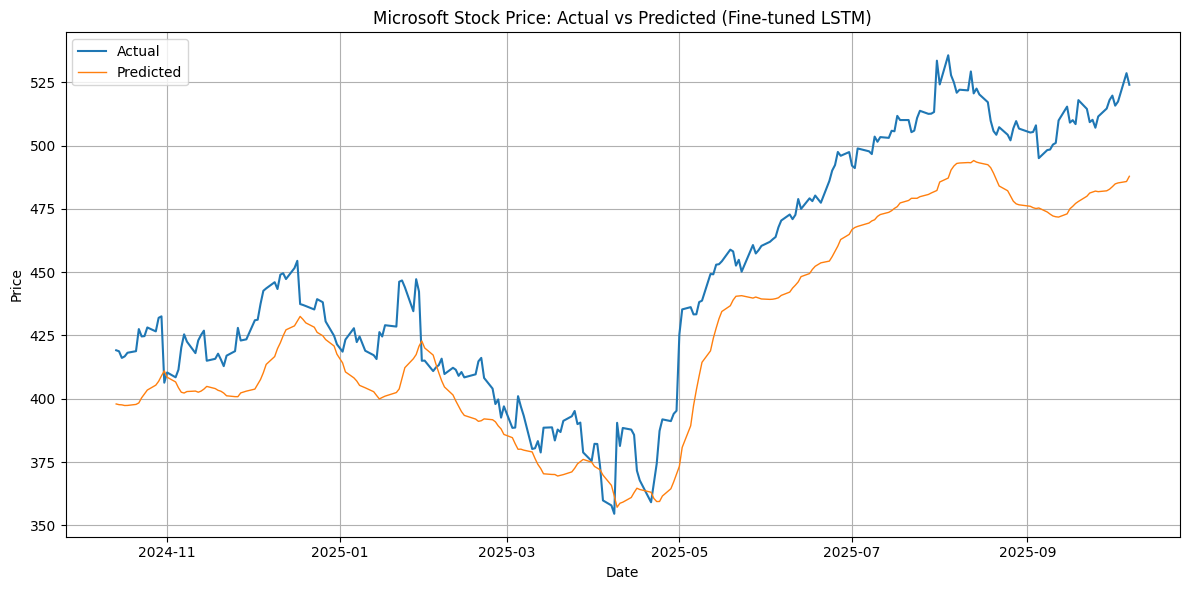

All steps completed successfully ✅


In [11]:
# --------------------------
# 7) Visualization: Actual vs Predicted
# --------------------------
test_start_idx = SEQ_LEN + int(num_samples * 0.9)
test_dates = df.index[test_start_idx:test_start_idx + len(y_test_actual)]

plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_actual, label="Actual", linewidth=1.5)
plt.plot(test_dates, y_pred_actual, label="Predicted", linewidth=1.0)
plt.title("Microsoft Stock Price: Actual vs Predicted (Fine-tuned LSTM)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("All steps completed successfully ✅")